<a href="https://colab.research.google.com/github/kozz84/Image-analysis/blob/main/Image_analysis_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center>
  <a href="" target="_blank">
  <img alt='Thumbnail for a video showing 3 cool Google Colab features' src="https://lh3.googleusercontent.com/8f6KyXu7OCkY5E4BC1v7kgFbzpscRsT326y8SwrClbMc3ptYRqMHcccIituJQOivN4iP4xCNGbVKLatIvLfnwOEdaJTxNf1YDViDy35FeXh8daUdOyxOqGr0DgLtUoAteTNlqLwneRo24R7JY84i7SebCYo4F5TtmFHA3wsmDS-RIYyAFkmhTEsT4QKR0BvKW6lYnwNy_pjAMXL35JGIchtBFfIFsIzGVKtZLldsOmbFb3D_Ly71HmQvy2zi3xSwe_PLs8aUZ4BjR4sorbomNULOKh6zave_pL0O559h4gcs-r2U5AZLRJaxS-SXhFfUhEPC6I0WPJW3IFpDOqZFP7HFVUPyXwbWvh8jTtl8_hBOJW1GeD7xBqojQxEykMVa7tCIEhbA8izuXVhFZF88qvqFVsspfbtN6Cy3_wL3ksVrzXg-PJ1dXDPvpMwPLxpZV-haviWEuPxDtT_weV6pKgFmEwHmHH9rgPQIXmxStupc-dBGl647taYVeUUmncmTVTIMBBCQMcZByRzf3oKptFwYdGy6Yer-xjYvZ523_VNn4ni_YNU9f4mTaeCKN2AlScHHhrFfDKUTHyuQsbtOjh67GVXSi5j2ibK2Y1VJe7uMr6171k1m232F0d63k4EksMreQRbbVbtflYpcKB7epF1FY6P8SHCWvAKBJjS60joXBYaUdQQly6GreRAtnKkokfy9LJVfn7kC_0nyT0Eth4g_Y1GN3LyHPrmr3dHqrz38B3kaDpsdoyeM5ZGYeglPTz2UKbgHtLXVrK-cfnfORxQf8Ax4jK-VQtxx_v6d6MHPGd18KaSfGRdvYI-EGpIohPLWYlIfvjyuNylJKUU7rWBXHw0vNfHdvtiiI_dw9ZIiY84OqtXRubBPAPMFz--fvZWi17cBDpKOTR-BeK_SJautIcIA3P8QxhimZTw4C3pEIxnouQy22cuUtth2OKkPtTG4lgJIubSPYKxVN9ppVECJRZSefLOBV2giOWgJyZW-Xgr3VygyB2A9=w1658-h269-no?authuser=1" >
  </a>
</center>



# Code

In [98]:
import glob, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image
import pandas as pd
import seaborn as sns

from skimage import io,morphology
from skimage.restoration import (denoise_tv_chambolle, denoise_bilateral,
                                 denoise_wavelet, estimate_sigma)
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops, regionprops_table,perimeter
from skimage.color import label2rgb

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
def loadfile(filepath):
    img = io.imread(filepath, as_gray=True)
    img = np.array(img).astype(np.int32)
    txtfile= filepath.split('.')[0]+'.txt'
    with open(txtfile,'r') as txt_file:
        txt = txt_file.read()
        del txt_file
        txt=txt.split('\n')
        txt=txt[1:-1]
        sem_dict = {}
        for row in txt:
            row = row.split('=')
            sem_dict.update({row[0]:  row[1]}) 
        width, height = sem_dict['DataSize'].split('x')
        width, height = int(width), int(height)
        if height == 1920:
            img = img[0:1780,0:2560]
            height = 1780
        pixelsize = float(sem_dict['PixelSize'])
        #print('FILE NAME:',sem_dict['ImageName'])
        #print('DATE:',sem_dict['Date'] )   
        #print('IMAGE SIZE [pixels]:', width,'x',height) 
        #print('PIXEL SIZE [nm]:', sem_dict['PixelSize'],)

        #print('IMAGE SIZE [nm]:', 
        #    round(width*float(sem_dict['PixelSize']),0), 
        #    'x',
         #   round(height*float(sem_dict['PixelSize']),0))
        #print('IMAGE AREA [nm]:', width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize']))
        image_area = width*float(sem_dict['PixelSize'])*height*float(sem_dict['PixelSize'])
    textstr = '\n'.join((
        'FILE NAME: '+sem_dict['ImageName'],
        'PIXEL SIZE [nm]: '+str(round(float(sem_dict['PixelSize']),2)),
        'IMAGE SIZE [nm]: '+str(int(width*float(sem_dict['PixelSize'])))+'x'+str(int(height*float(sem_dict['PixelSize'])))))       
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img,vmax=255, cmap='gray')
    plt.text(100, 100, textstr, fontsize=14,
        verticalalignment='top', bbox=props)
    plt.show()
    return img, sem_dict,width, height,pixelsize,image_area

In [100]:
def image_info(img):
    im = img.copy()
    print('Max:',im.max())
    print('Min:',im.min())
    print('Median:',np.median(im))
    print('Average:',np.average(im))
    im_flatten = im.flatten()
    print('IMAGE:')
    im_flatten = im.flatten()
    plt.figure(figsize=(5,5))
    plt.axis('off')
    plt.imshow(im,vmax=255, cmap='gray')
    plt.show()

    print('IMAGE HIST:')
    plt.figure(figsize=(4,2))
    plt.hist(im_flatten, bins=256,histtype='stepfilled', range=(im.min(),im.max()))
    plt.yscale('log')
    plt.show()

    median_img=[]
    
    average_img =[]
    max_img = []
    num_rec_x=20
    num_rec_y=20
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            median_img.append(int(np.median(im[x_min:x_max,y_min:y_max])))
            average_img.append(int(np.average(im[x_min:x_max,y_min:y_max])))
            max_img.append(int(np.max(im[x_min:x_max,y_min:y_max])))
    print('Average:')            
    plt.figure(figsize=(10,8))
    plt.plot(average_img)
    plt.show()
    #plt.plot(max_img)
    plt.boxplot(median_img)
    plt.show()
    Q1 = np.percentile(median_img , 25)
    print(Q1)
    Q3 = np.percentile(median_img , 75)
    print(Q3)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)
    print(upper_bound)
    print(lower_bound)
    median_img = np.reshape(median_img, (20, 20))
    average_img =np.reshape(average_img,(20,20))
    max_img=np.reshape(max_img,(20,20))
    print('Median_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(median_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('Average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()
    print('max/average_HM')
    plt.figure(figsize=(17, 10))
    sns.heatmap(max_img/average_img,annot=True,fmt='.0f')
    plt.axis(False)
    plt.show()

In [116]:
def uniform(num_rec_x,num_rec_y):
    img2 = np.copy(img)
    img2 = denoise_tv_chambolle(img2, weight=6)
    rec_size_x = int(int(height)/num_rec_x)
    rec_size_y = int(int(width)/num_rec_y)
    print("Median Rectangle Box size:",rec_size_x,"x", rec_size_y)
    print("Median intensity:",np.median(img))
    median_img=[]
    mask = np.zeros(shape=(1780,2560), dtype=bool)
    for i in range(num_rec_x):
        for j in range(num_rec_y):
            x_min=i*rec_size_x
            y_min=j*rec_size_y
            x_max=x_min+rec_size_x
            y_max=y_min+rec_size_y
            if j == (num_rec_y-1):
                y_max = width
            if i == (num_rec_x-1):
                x_max = height
            median_img.append(np.median(img[x_min:x_max,y_min:y_max]))
            img2[x_min:x_max,y_min:y_max]=img[x_min:x_max,y_min:y_max] - np.median(img[x_min:x_max,y_min:y_max])
    Q1 = np.percentile(median_img , 25)
    Q3 = np.percentile(median_img , 75)
    IQR = Q3 - Q1
    upper_bound = Q3+(1.5*IQR)
    lower_bound = Q1-(1.5*IQR)

    for i in range(num_rec_x):
        for j in range(num_rec_y):
             x_min=i*rec_size_x
             y_min=j*rec_size_y
             x_max=x_min+rec_size_x
             y_max=y_min+rec_size_y
             if np.median(img[x_min:x_max,y_min:y_max]) > upper_bound or np.median(img[x_min:x_max,y_min:y_max]) < lower_bound :
                #print(np.median(img[x_min:x_max,y_min:y_max]))
                img2[x_min:x_max,y_min:y_max] = 0
                mask[x_min:x_max,y_min:y_max] = True
    img2[img2<0] = 0
    mask[0,0:]=True
    mask[-1,0:]=True
    mask[0:,0]=True
    mask[0:,-1]=True
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(img2,vmax=img2.max())
    plt.show()
    plt.figure(figsize=(10,10))
    plt.axis('off')
    plt.imshow(mask)
    plt.show()
    return img2, median_img, mask

In [102]:
def histograms():
    img_flatten = img.flatten()
    img2_flatten = img2.flatten()
    fig, (ax1, ax2) = plt.subplots(2)
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    fig.suptitle('Histograms')
    ax1.hist(img_flatten, bins=256, range=(0,255))
    ax2.hist(img2_flatten, bins=256, range=(0,155))

In [103]:
def segmentation(low,denoise=6,small=15,erosion=1):
    img_denoised = denoise_tv_chambolle(img2, weight=denoise)
    img_denoised = img2.copy()
    img_segm = (img2 > np.median(img_denoised)+low) & (img_denoised <= 255)
    img_segm = img_segm+mask
    img_segm = clear_border(img_segm)
    img_segm = morphology.remove_small_objects(img_segm, small)
    img_segm = morphology.area_closing(img_segm)
    #for i in range(erosion):
    #    img_segm = morphology.binary_erosion(img_segm)
    #img_segm = morphology.remove_small_objects(img_segm, small)
    #for i in range(erosion-1):     
    #    img_segm = morphology.binary_dilation(img_segm)
    #img_segm = morphology.binary_dilation(img_segm)
    #img_segm = morphology.binary_erosion(img_segm)
    #plt.imshow(img_segm[1000:1500,500:1000])
    #plt.axis('off')
    #plt.show()

    return img_segm


In [104]:
def label_img():
    img2_label = label(img_segm)
    #img2_label = clear_border(img2_label, mask=mask,bgval=0)
    img2_label_overlay = label2rgb(img2_label, bg_label=0)
    props = regionprops(img2_label, extra_properties=())
    props = regionprops_table(img2_label, img_segm,
                           properties=['mean_intensity',
                                       'area',
                                       'convex_area',
                                       'equivalent_diameter', 
                                       'major_axis_length', 
                                       'minor_axis_length',
                                       'bbox', 'perimeter',
                                       'feret_diameter_max', 
                                       'image',
                                       'convex_image'
                                       ]
                              )
    props = pd.DataFrame(props)
    props['img'] = [img]*len(props)
    for i in range(len(props)):
        props.loc[i,'img'] = [img[int(props['bbox-0'][i]):int(props['bbox-2'][i]),
                                  int(props['bbox-1'][i]):int(props['bbox-3'][i])]]
    data_nm = props.copy()
    data_nm['convex_perimeter'] = data_nm['convex_image'].apply(lambda x: perimeter(x))
    data_nm = data_nm.drop(columns=[
                                 #   'image',
                                    'bbox-0', 
                                    'bbox-1', 
                                    'bbox-2', 
                                    'bbox-3',
                              #      'img',
                           #         'mean_intensity',
                                  #  'convex_image'
                                    ])
    to_nm = ['equivalent_diameter',
       'major_axis_length', 'minor_axis_length', 'perimeter',
       'feret_diameter_max', 'convex_perimeter']

    to_nm2 = ['area', 'convex_area']
    data_nm['circularity'] = np.sqrt(4*np.pi*data_nm['area']/(data_nm['perimeter'])**2)
    data_nm.loc[data_nm['circularity'] >1 ,'circularity'] = 1
    for column in to_nm:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize)
    for column in to_nm2:
        data_nm[column] = data_nm[column].apply(lambda x:x*pixelsize*pixelsize)
    data_nm['aspect_ratio'] = data_nm['minor_axis_length']/data_nm['major_axis_length']
    data_nm['solidity'] =data_nm['area']/data_nm['convex_area']
    data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'convex_perimeter'] = data_nm.loc[(data_nm['convex_perimeter'] >data_nm['perimeter']), 'perimeter'].values
    data_nm['convexity'] = data_nm['convex_perimeter']/data_nm['perimeter']
    print('image area: ',image_area)
    print('image area_mask: ',image_area*(area_size_mask[False]/(area_size_mask[True]+area_size_mask[False])))
    data_nm['area_fraction']=data_nm['area']/image_area*(area_size_mask[False]/(area_size_mask[True]+area_size_mask[False]))
    csv_file_name=sem_dict['ImageName'].split('.')[0]
    data_nm.to_csv(csv_file_name+'.csv')
    return img2_label, img2_label_overlay, data_nm

In [105]:
def quick_label_img():
    img2_label = label(img_segm)
    img2_label = clear_border(img2_label, mask=mask)
    particles = img2_label.max()
    return particles

# User interactions

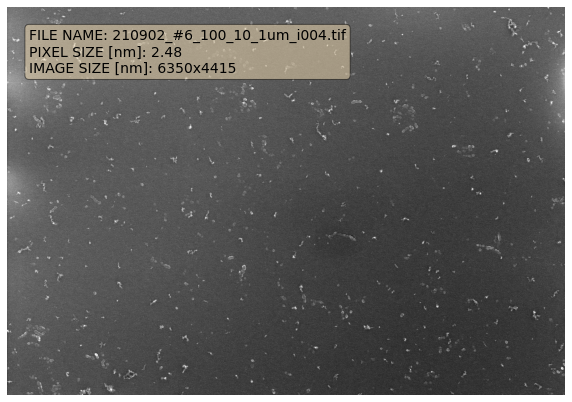

In [110]:
#@title String fields

file_path = '/content/drive/MyDrive/CIOP/images/210902_#6_100_10_1um_i004.tif' #@param {type:"string"}
show_info = False #@param {type:"boolean"}
img,sem_dict,width, height,pixelsize,image_area = loadfile(file_path)
if show_info:
    print(pd.DataFrame(sem_dict,index=[0]).T)

Median Rectangle Box size: 35 x 51
Median intensity: 113.0


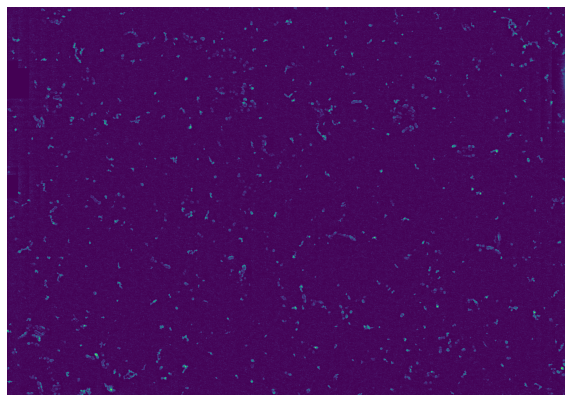

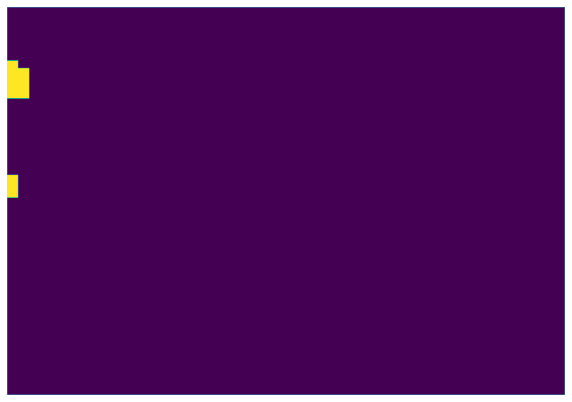

In [117]:
#@title Number fields
#@title ## Markdown
#@markdown Insert number of rectangles in the image 
number_slider = 50 #@param {type:"slider", min:1, max:50, step:1}
img2, median_img,mask = uniform(number_slider,number_slider)
unique, counts = np.unique(mask, return_counts=True)
area_size_mask = dict(zip(unique, counts))

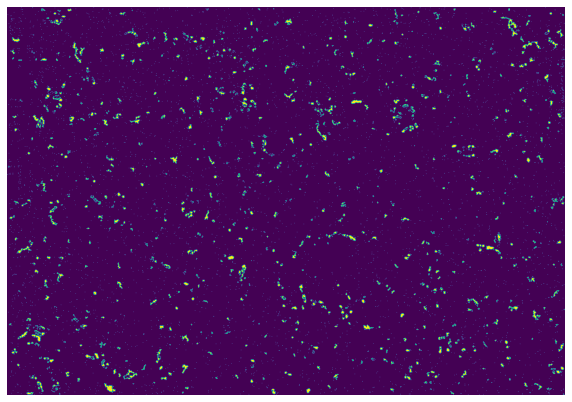

In [127]:
#@title Number fields
#@title ## Markdown
#@markdown Image Segmentation
low = 20 #@param {type:"slider", min:1, max:50, step:1}
denoise = 6 #@param {type:"slider", min:1, max:10, step:1}
small = 2 #@param {type:"slider", min:0, max:50, step:1}
erosion =1 #@param {type:"slider", min:0, max:5, step:1}

img_segm = segmentation(low, denoise,small,erosion)
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img_segm)
plt.show()

In [ ]:
img2_label, img2_label_overlay, data_nm = label_img()

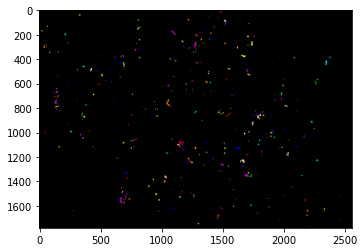

In [ ]:
plt.imshow(img2_label_overlay, vmax=1)

In [ ]:
data_nm[data_nm['area']!=data_nm['area'].max()]['area_fraction'].sum()

0.007919153792134833

In [ ]:
data_nm['area_fraction'].sum()

0.008027782654494383

In [ ]:
bin_file_name = sem_dict['ImageName'].split('.')[0]+'_bin.png'
io.imsave(bin_file_name,img2_label_overlay)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#3_50_30_1um_i003_bin.png is a low contrast image
  


In [ ]:
mask_file_name = sem_dict['ImageName'].split('.')[0]+'_mask.png'
io.imsave(mask_file_name,mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#3_50_30_1um_i003_mask.png is a boolean image: setting True to 255 and False to 0. To silence this warning, please convert the image using img_as_ubyte.
  


# New Section

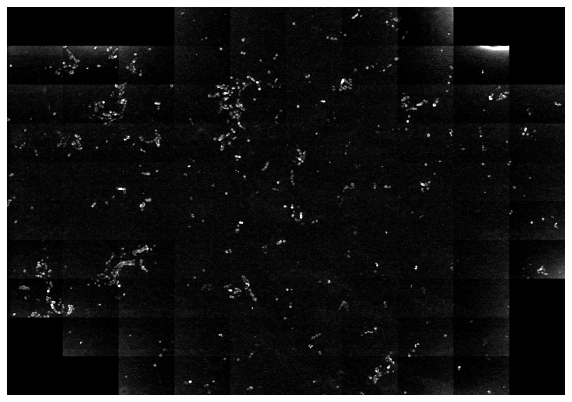

In [ ]:
plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(img2,vmax=100, cmap='gray')
plt.show()

In [ ]:
#image_info(img2)

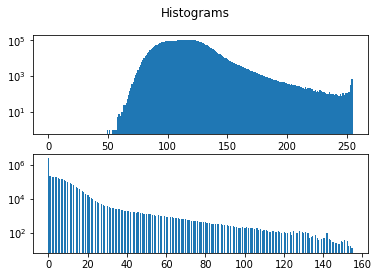

In [ ]:
histograms()

1%, 2%, 3%, 4%, 5%, 6%, 7%, 8%, 9%, 10%, 11%, 12%, 13%, 14%, 15%, 16%, 17%, 18%, 19%, 20%, 21%, 22%, 23%, 24%, 25%, 26%, 27%, 28%, 29%, 30%, 31%, 32%, 33%, 34%, 35%, 36%, 37%, 38%, 39%, 40%, 41%, 42%, 43%, 44%, 45%, 46%, 47%, 48%, 49%, 50%, 51%, 52%, 53%, 54%, 55%, 56%, 57%, 58%, 59%, 60%, 61%, 62%, 63%, 64%, 65%, 66%, 67%, 68%, 69%, 70%, 71%, 72%, 73%, 74%, 75%, 76%, 77%, 78%, 79%, 80%, 81%, 82%, 83%, 84%, 85%, 86%, 87%, 88%, 89%, 90%, 91%, 92%, 93%, 94%, 95%, 96%, 97%, 98%, 99%, 100%, 

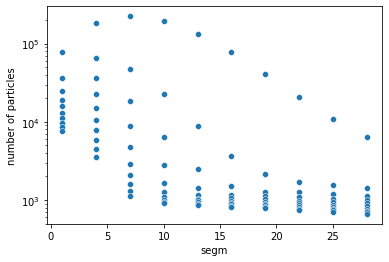

In [ ]:
show_images = False
max_cutoff = 30
min_size = 30
step=3
do_fitting = True
particles = []
counter=0
if show_images and do_fitting:
    plt.imshow(img[1000:1500,500:1000],vmin=0,cmap='gray')
    plt.text(440,30,'img',backgroundcolor='white')
    plt.axis('off')
    plt.show()
if do_fitting:
    for i in range(1,max_cutoff+1,step):
        for j in range(1,min_size+1,step):
            counter+=1
            print(round(counter/((max_cutoff/step)*(min_size/step))*100), end = '%, ')
            img_segm = segmentation(i,6,j,1)
            #img2_label, img2_label_overlay, data_nm = label_img()
            if show_images:
                plt.imshow(img_segm[1000:1500,500:1000],vmin=0,cmap='gray')
                plt.text(450,50,i,backgroundcolor='white')
                plt.axis('off')
                plt.show()
            n_particles = quick_label_img()
            particles.append([i,j,n_particles])
    particles = pd.DataFrame(particles, columns=(['segm','low','number of particles']))

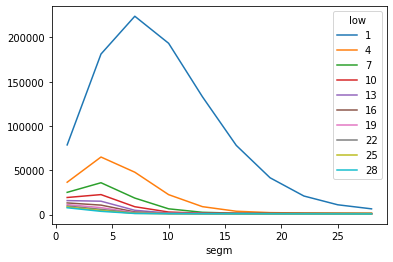

In [ ]:
pd.pivot_table(particles,'number of particles', index='segm',columns='low').plot()

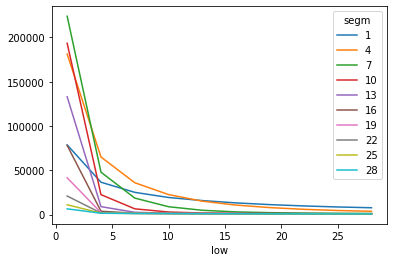

In [ ]:
pd.pivot_table(particles,'number of particles', index='low',columns='segm').plot()

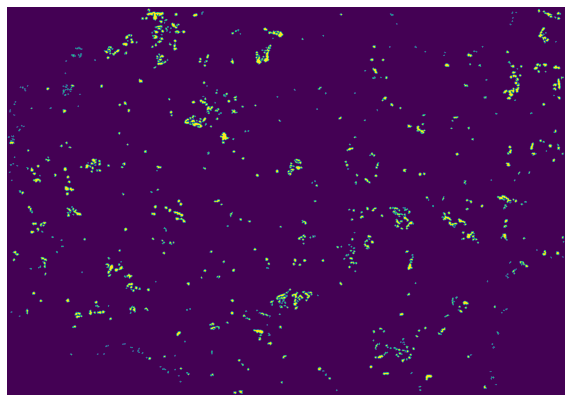

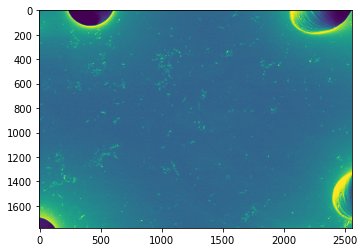

In [ ]:
plt.imshow(img)

# Data presantation

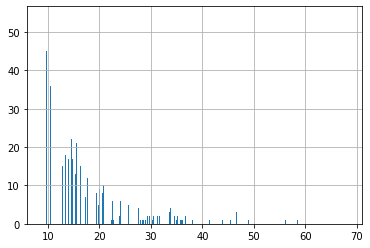

In [ ]:
data_nm['equivalent_diameter'].hist(bins=1000)

In [ ]:
data_nm.sort_values('area',ascending=False).head(10).index

Int64Index([111, 1015, 2800, 2063, 2271, 3193, 3087, 349, 340, 1194], dtype='int64')

In [ ]:
data_nm.iloc[3193]

mean_intensity                                                155.238313
area                                                         6712.624568
convex_area                                                  9536.726013
equivalent_diameter                                            92.448791
major_axis_length                                             142.776171
minor_axis_length                                              71.246973
perimeter                                                     580.857922
feret_diameter_max                                            161.230485
image                  [[False, True, True, True, False, False, False...
convex_image           [[False, True, True, True, True, True, False, ...
img                    [[113, 122, 126, 124, 111, 106, 105, 109, 114,...
convex_perimeter                                              403.349493
circularity                                                     0.500013
aspect_ratio                                       

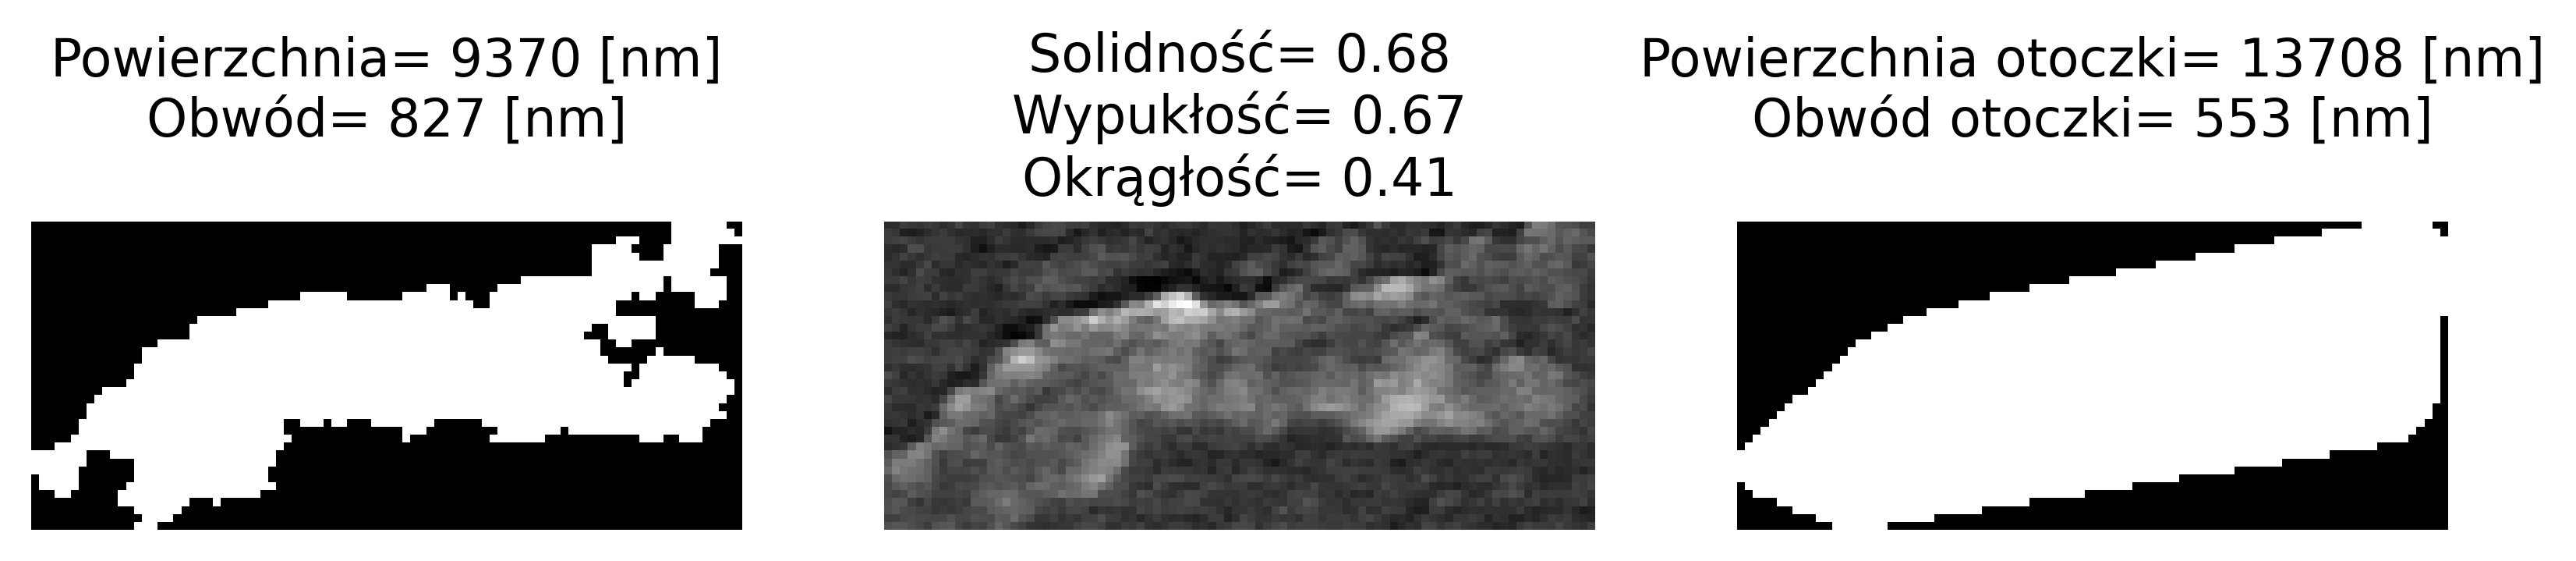

In [ ]:
index=543
plt.figure(figsize=(10,10),dpi=400)
plt.subplot(1,3,1)
plt.axis('off')
plt.title('Powierzchnia= '+str(int(data_nm['area'][index]))+' [nm]\n'
          'Obwód= '+str(round(data_nm['perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['image'][index],cmap='gray')
plt.subplot(1,3,2)
plt.axis('off')
plt.title('Solidność= '+str(round(data_nm['solidity'][index],2))+'\n'
        'Wypukłość= '+str(round(data_nm['convexity'][index],2))+'\n'
        'Okrągłość= '+str(round(data_nm['circularity'][index],2)))
plt.imshow(data_nm['img'][index],cmap='gray')
plt.subplot(1,3,3)
plt.axis('off')
plt.title('Powierzchnia otoczki= '+str(int(data_nm['convex_area'][index]))+' [nm]\n'
           'Obwód otoczki= '+str(round(data_nm['convex_perimeter'][index]))+' [nm]\n')
plt.imshow(data_nm['convex_image'][index],cmap='gray')
plt.show()

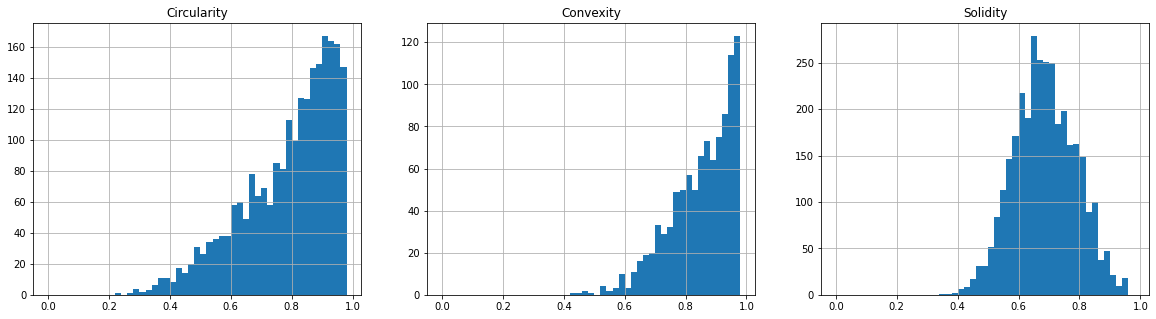

In [ ]:
bins = np.arange(0, 1, 0.02)
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.title('Circularity')
data_nm['circularity'].hist(bins=bins)

plt.subplot(1,3,2)
plt.title('Convexity')
data_nm['convexity'].hist(bins=bins)

plt.subplot(1,3,3)
plt.title('Solidity')
data_nm['solidity'].hist(bins=bins)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: 210902_#9_150_30_1um_i003_bin.png is a low contrast image
  


# iteration

In [ ]:
import glob
path = "/content/*.*"
filelist = []
for file in glob.glob(path):
    if file.endswith("tif"): 
        print(file)
        filelist.append(file)

/content/210902_#6_100_10_1um_i003.tif
/content/210902_#7_150_10_1um_i001.tif
/content/210902_#1_50_10_1um_i006.tif
/content/210902_#2_50_20_1um_i002.tif
/content/210902_#3_50_30_1um_i001.tif
/content/210902_#5_100_20_1um_i002.tif
/content/210902_#5_100_20_1um_i004.tif
/content/210902_#1_50_10_1um_i005.tif
/content/210902_#9_150_30_1um_i003.tif
/content/210902_#6_100_10_1um_i002.tif
/content/210902_#7_150_10_1um_i005.tif
/content/210902_#4_100_30_1um_i003.tif
/content/210902_#6_100_10_1um_i004.tif
/content/210902_#7_150_10_1um_i003.tif
/content/210902_#3_50_30_1um_i002.tif
/content/210902_#8_150_20_1um_i004.tif
/content/210902_#9_150_30_1um_i002.tif
/content/210902_#6_100_10_1um_i001.tif
/content/210902_#6_100_10_1um_i005.tif
/content/210902_#2_50_20_1um_i004.tif
/content/210902_#4_100_30_1um_i005.tif
/content/210902_#8_150_20_1um_i002.tif
/content/210902_#9_150_30_1um_i005.tif
/content/210902_#7_150_10_1um_i004.tif
/content/210902_#4_100_30_1um_i002.tif
/content/210902_#1_50_10_1um_i0

In [ ]:
filelist.sort()

In [ ]:
filelist

['/content/210902_#1_50_10_1um_i004.tif',
 '/content/210902_#1_50_10_1um_i005.tif',
 '/content/210902_#1_50_10_1um_i006.tif',
 '/content/210902_#1_50_10_1um_i007.tif',
 '/content/210902_#2_50_20_1um_i001.tif',
 '/content/210902_#2_50_20_1um_i002.tif',
 '/content/210902_#2_50_20_1um_i003.tif',
 '/content/210902_#2_50_20_1um_i004.tif',
 '/content/210902_#3_50_30_1um_i001.tif',
 '/content/210902_#3_50_30_1um_i002.tif',
 '/content/210902_#3_50_30_1um_i003.tif',
 '/content/210902_#3_50_30_1um_i004.tif',
 '/content/210902_#4_100_30_1um_i002.tif',
 '/content/210902_#4_100_30_1um_i003.tif',
 '/content/210902_#4_100_30_1um_i004.tif',
 '/content/210902_#4_100_30_1um_i005.tif',
 '/content/210902_#5_100_20_1um_i001.tif',
 '/content/210902_#5_100_20_1um_i002.tif',
 '/content/210902_#5_100_20_1um_i003.tif',
 '/content/210902_#5_100_20_1um_i004.tif',
 '/content/210902_#5_100_20_1um_i005.tif',
 '/content/210902_#6_100_10_1um_i001.tif',
 '/content/210902_#6_100_10_1um_i002.tif',
 '/content/210902_#6_10

In [ ]:
sem_dict['ImageName']

'210902_#1_50_10_1um_i007.tif'

In [ ]:
area_fraction = pd.DataFrame(columns=['name','area_fraction'])

FILE NAME: 210902_#1_50_10_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 91.0
MASK SIZE: 0.8938094715589887


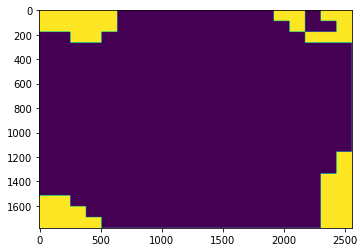

image area:  28036743.932750277
image area_mask:  25059507.278766207
area_max:  8232.348003427816


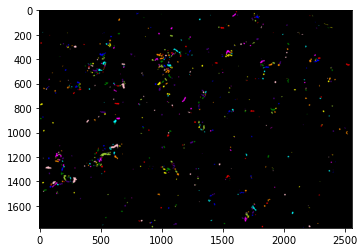


 area fraction:  0.014564025909246603 

FILE NAME: 210902_#1_50_10_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 105.0
MASK SIZE: 0.8386060393258427


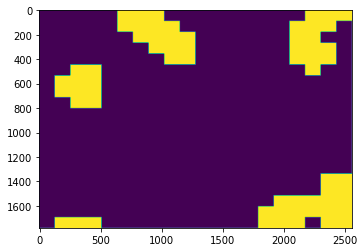

image area:  28036743.932750277
image area_mask:  23511782.78503656
area_max:  911286.4687112835


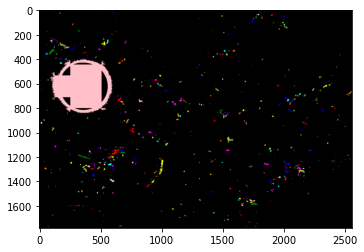


 area fraction:  0.011338701565779456 

FILE NAME: 210902_#1_50_10_1um_i006.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 112.0
MASK SIZE: 0.8861328125


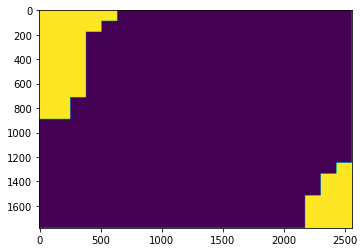

image area:  28036743.932750277
image area_mask:  24844278.754470315
area_max:  7395.577204873121


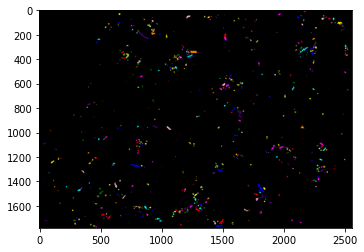


 area fraction:  0.013914470929778025 

FILE NAME: 210902_#1_50_10_1um_i007.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 110.0
MASK SIZE: 0.940851255266854


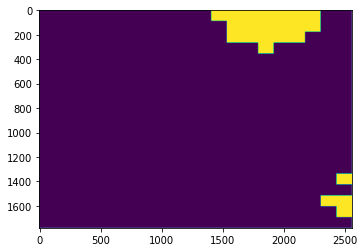

image area:  28036743.932750277
image area_mask:  26378405.72272345
area_max:  6491.126415258854


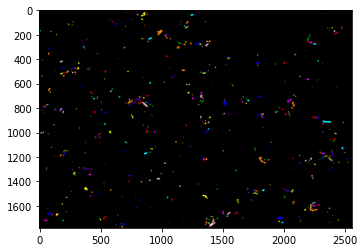


 area fraction:  0.01435681864109143 

FILE NAME: 210902_#2_50_20_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 101.0
MASK SIZE: 0.876348753511236


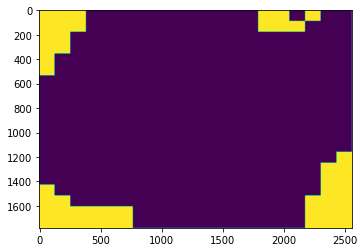

image area:  28036743.932750277
image area_mask:  24569965.597979415
area_max:  8736.87157314462


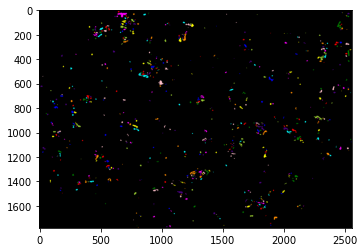


 area fraction:  0.01547245572907292 

FILE NAME: 210902_#2_50_20_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 98.0
MASK SIZE: 0.8787840150983146


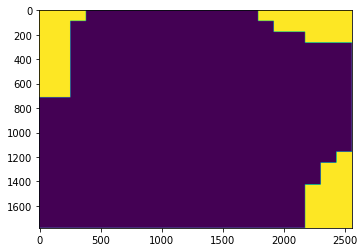

image area:  28036743.932750277
image area_mask:  24638242.4035056
area_max:  8078.529841928792


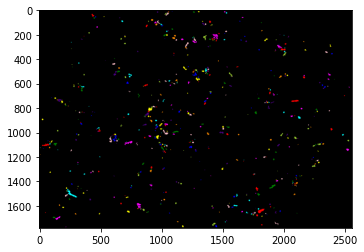


 area fraction:  0.012741866805995601 

FILE NAME: 210902_#2_50_20_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 97.0
MASK SIZE: 0.906166169241573


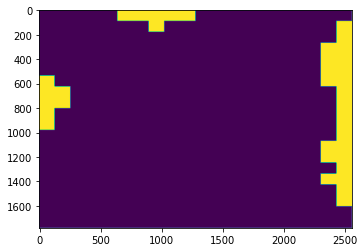

image area:  28036743.932750277
image area_mask:  25405948.847547233
area_max:  8441.54070306649


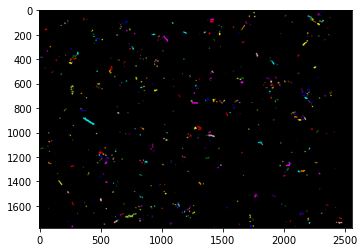


 area fraction:  0.012301492106145479 

FILE NAME: 210902_#2_50_20_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 100.0
MASK SIZE: 0.8659816099016854


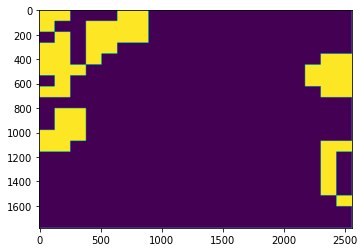

image area:  28036743.932750277
image area_mask:  24279304.647284396
area_max:  4971.402979648487


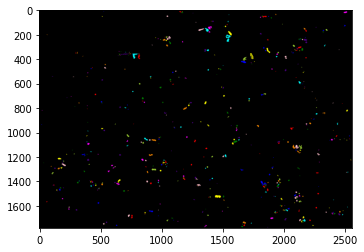


 area fraction:  0.009309758406307884 

FILE NAME: 210902_#3_50_30_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 86.0
MASK SIZE: 0.8813035463483146


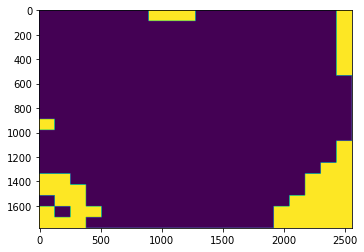

image area:  28036743.932750277
image area_mask:  24708881.855992414
area_max:  7346.355393193433


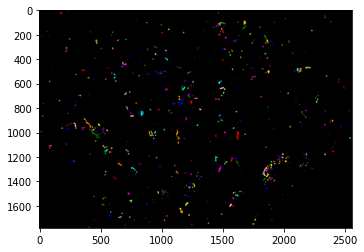


 area fraction:  0.012183874541192236 

FILE NAME: 210902_#3_50_30_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 86.0
MASK SIZE: 0.8661606829353933


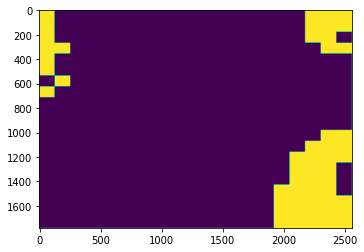

image area:  28036743.932750277
image area_mask:  24284325.272075724
area_max:  5457.468369985407


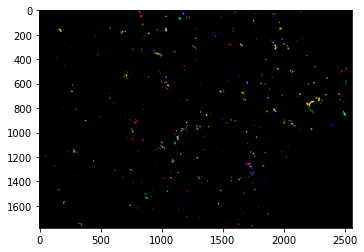


 area fraction:  0.007058274367854627 

FILE NAME: 210902_#3_50_30_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 85.0
MASK SIZE: 0.8038380003511236


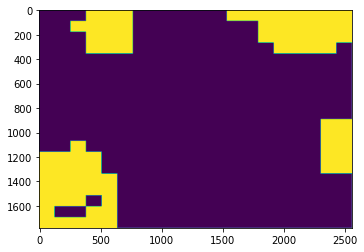

image area:  28036743.932750277
image area_mask:  22537000.17925848
area_max:  3045.5995976806944


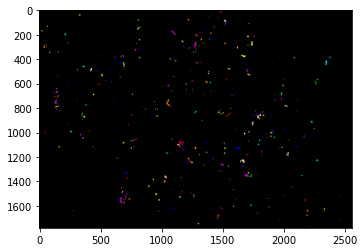


 area fraction:  0.0064530367562422 

FILE NAME: 210902_#3_50_30_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 81.0
MASK SIZE: 0.8711242538623596


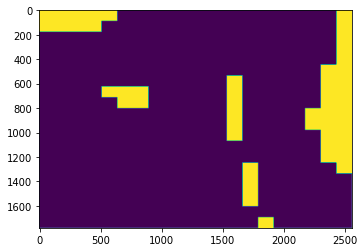

image area:  28036743.932750277
image area_mask:  24423487.63914712
area_max:  424538.12573730893


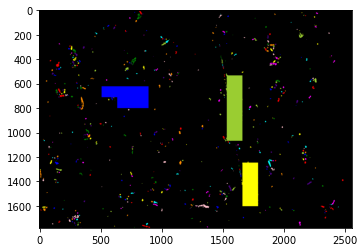


 area fraction:  0.01265967133498797 

FILE NAME: 210902_#4_100_30_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 110.0
MASK SIZE: 0.8737561446629214


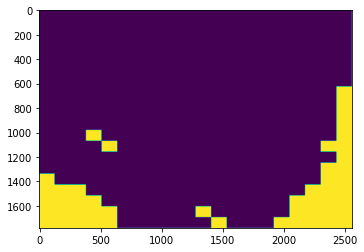

image area:  28036743.932750277
image area_mask:  24497277.287581436
area_max:  148889.8276045962


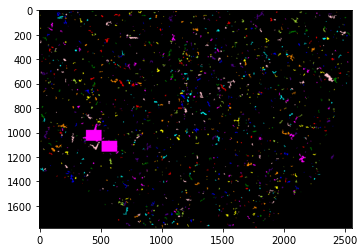


 area fraction:  0.028744521623536086 

FILE NAME: 210902_#4_100_30_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 116.0
MASK SIZE: 0.9459658093398876


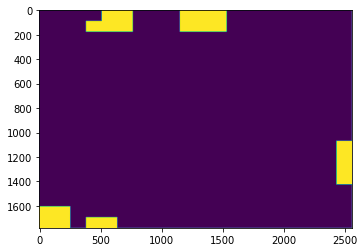

image area:  28036743.932750277
image area_mask:  26521801.165599298
area_max:  8232.348003427816


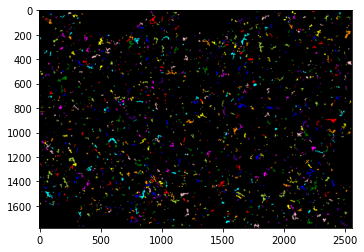


 area fraction:  0.04937755520241141 

FILE NAME: 210902_#4_100_30_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 120.0
MASK SIZE: 0.9460349367977529


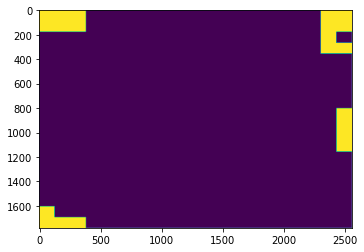

image area:  28036743.932750277
image area_mask:  26523739.27443419
area_max:  15726.368831660315


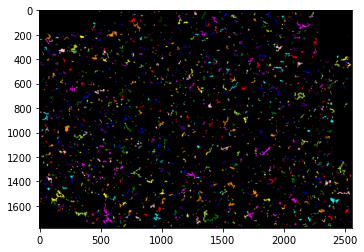


 area fraction:  0.051338505817919496 

FILE NAME: 210902_#4_100_30_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 122.0
MASK SIZE: 0.9384963132022472


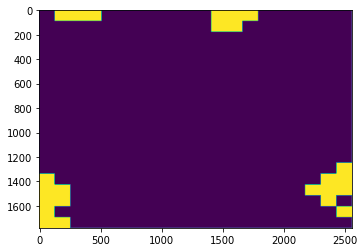

image area:  28036743.932750277
image area_mask:  26312380.815081608
area_max:  13326.805512275523


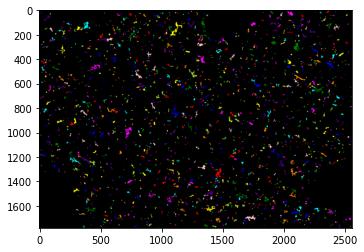


 area fraction:  0.04564933557152794 

FILE NAME: 210902_#5_100_20_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 90.0
MASK SIZE: 0.8911071365870786


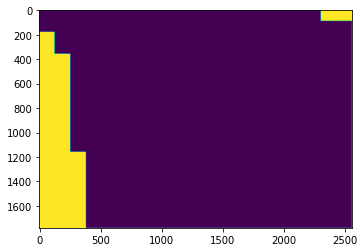

image area:  28036743.932750277
image area_mask:  24983742.60513825
area_max:  3962.3558402148838


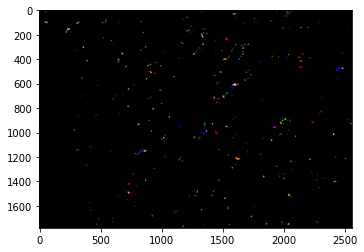


 area fraction:  0.0054782907576260585 

FILE NAME: 210902_#5_100_20_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 90.0
MASK SIZE: 0.9012023788623595


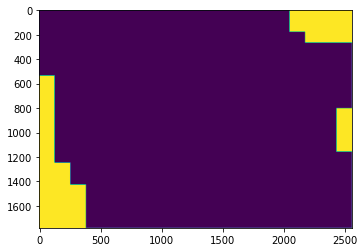

image area:  28036743.932750277
image area_mask:  25266780.327749375
area_max:  5186.748405747123


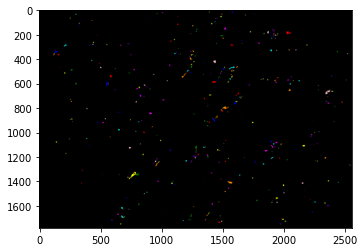


 area fraction:  0.005639634619829496 

FILE NAME: 210902_#5_100_20_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 73.0
MASK SIZE: 0.8760913360252809


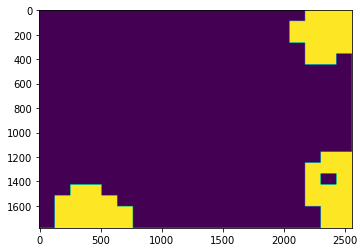

image area:  28036743.932750277
image area_mask:  24562748.44984188
area_max:  12889.961933618293


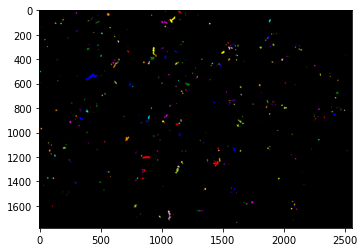


 area fraction:  0.008332365346734474 

FILE NAME: 210902_#5_100_20_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 114.0
MASK SIZE: 0.9682083918539326


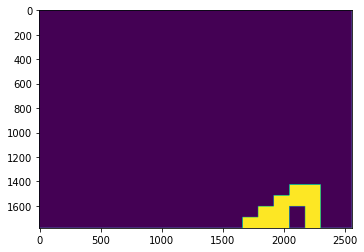

image area:  28036743.932750277
image area_mask:  27145410.755948648
area_max:  16993.83048241228


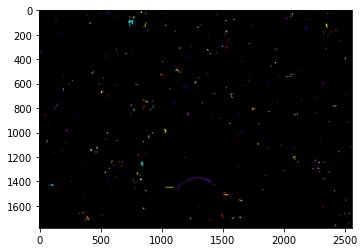


 area fraction:  0.00591213099177837 

FILE NAME: 210902_#5_100_20_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 103.0
MASK SIZE: 0.9757667661516853


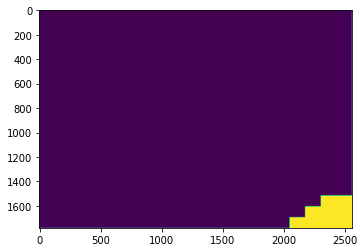

image area:  28036743.932750277
image area_mask:  27357322.960682623
area_max:  2251.8978843457257


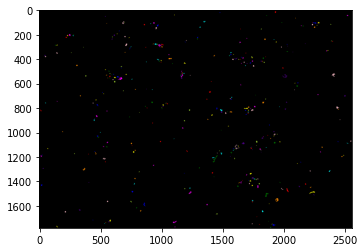


 area fraction:  0.004807313004763286 

FILE NAME: 210902_#6_100_10_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 140.0
MASK SIZE: 0.9956155635533708


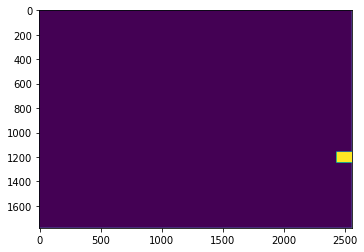

image area:  28036743.932750277
image area_mask:  27913818.610806715
area_max:  7143.315420014719


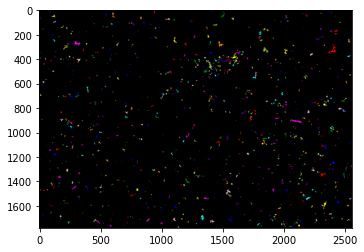


 area fraction:  0.018976518289435772 

FILE NAME: 210902_#6_100_10_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 127.0
MASK SIZE: 0.9956241221910113


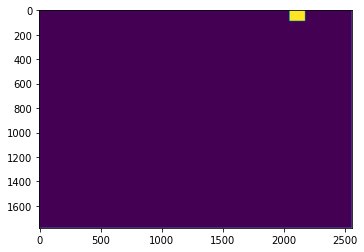

image area:  28036743.932750277
image area_mask:  27914058.567138657
area_max:  10841.104022451282


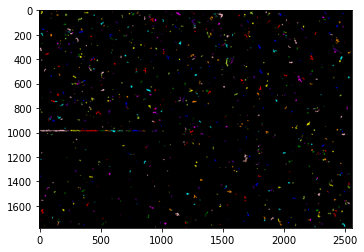


 area fraction:  0.019527718118157837 

FILE NAME: 210902_#6_100_10_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 116.0
MASK SIZE: 0.9906803019662921


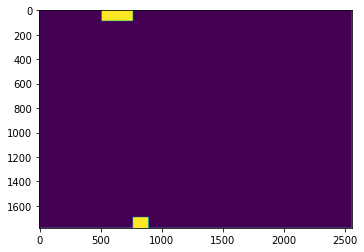

image area:  28036743.932750277
image area_mask:  27775449.945448652
area_max:  5765.104692983456


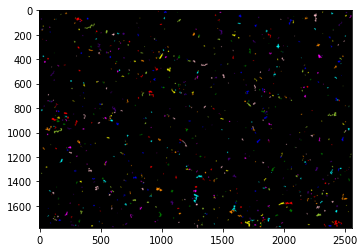


 area fraction:  0.01829653986413255 

FILE NAME: 210902_#6_100_10_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 113.0
MASK SIZE: 0.9956155635533708


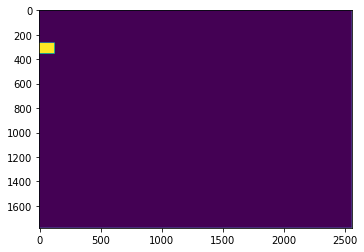

image area:  28036743.932750277
image area_mask:  27913818.610806715
area_max:  5586.675625644588


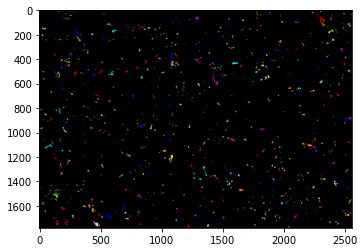


 area fraction:  0.020058481129743948 

FILE NAME: 210902_#6_100_10_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 124.0
MASK SIZE: 0.9485827773876404


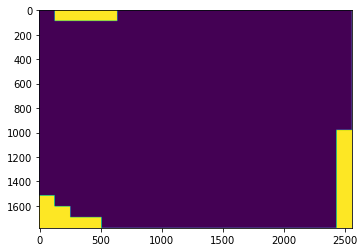

image area:  28036743.932750277
image area_mask:  26595172.428634334
area_max:  5463.621096445367


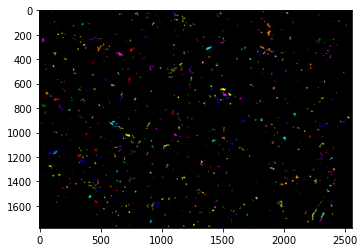


 area fraction:  0.01731713133894905 

FILE NAME: 210902_#7_150_10_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 107.0
MASK SIZE: 0.9980960323033707


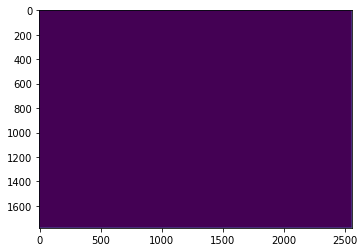

image area:  28036743.932750277
image area_mask:  27983362.877983656
area_max:  7924.7116804297675


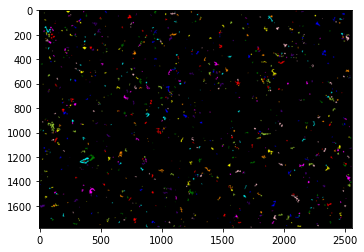


 area fraction:  0.023651117334990715 

FILE NAME: 210902_#7_150_10_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 117.0
MASK SIZE: 0.9907189255617977


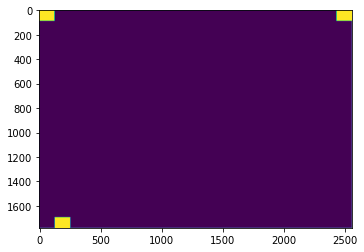

image area:  28036743.932750277
image area_mask:  27776532.825305607
area_max:  8663.038855625085


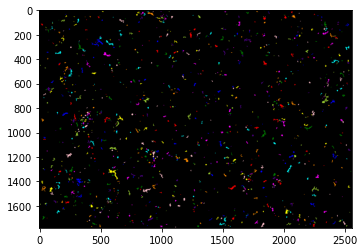


 area fraction:  0.026419243820146127 

FILE NAME: 210902_#7_150_10_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 103.0
MASK SIZE: 0.9881827159410113


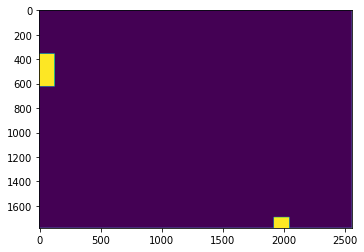

image area:  28036743.932750277
image area_mask:  27705425.765607838
area_max:  8767.635205444423


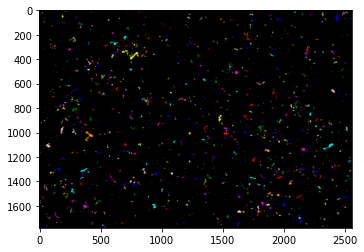


 area fraction:  0.023797230187083664 

FILE NAME: 210902_#7_150_10_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 130.0
MASK SIZE: 0.9184794153792135


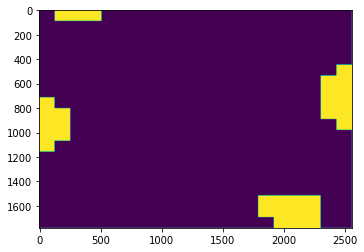

image area:  28036743.932750277
image area_mask:  25751172.176489186
area_max:  12606.936516460088


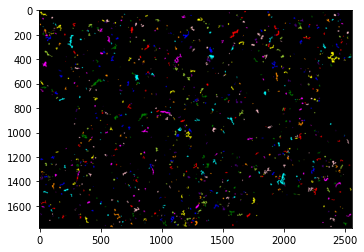


 area fraction:  0.030382302536378684 

FILE NAME: 210902_#7_150_10_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 137.0
MASK SIZE: 0.8861927229634832


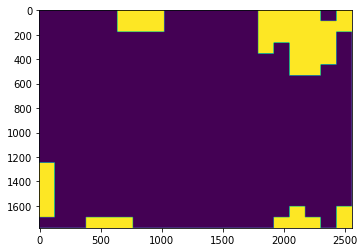

image area:  28036743.932750277
image area_mask:  24845958.448793884
area_max:  10564.231331753035


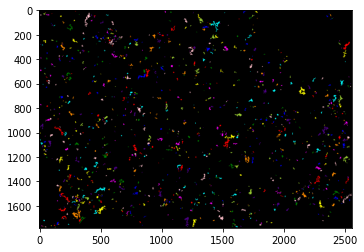


 area fraction:  0.028080142837792185 

FILE NAME: 210902_#8_150_20_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 122.0
MASK SIZE: 0.9708729810393258


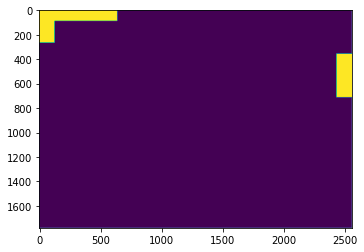

image area:  28036743.932750277
image area_mask:  27220117.160625495
area_max:  15314.136158842926


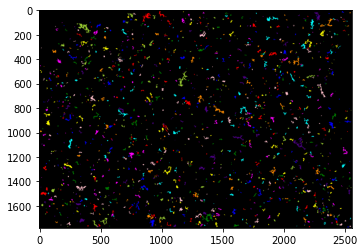


 area fraction:  0.04438684342958277 

FILE NAME: 210902_#8_150_20_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 135.0
MASK SIZE: 0.9708984375


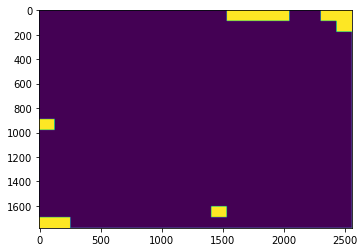

image area:  28036743.932750277
image area_mask:  27220830.87689485
area_max:  16372.405109956218


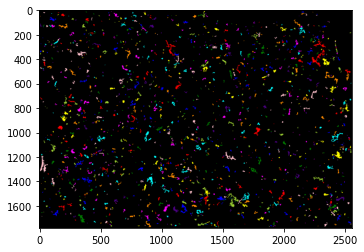


 area fraction:  0.049041365291295436 

FILE NAME: 210902_#8_150_20_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 135.0
MASK SIZE: 0.9385136499297753


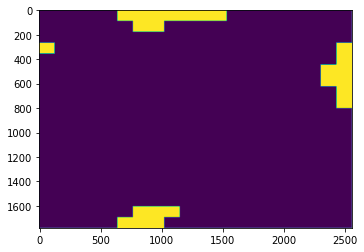

image area:  28036743.932750277
image area_mask:  26312866.880471945
area_max:  26192.15654005397


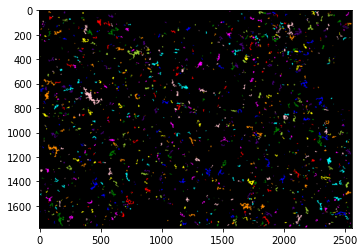


 area fraction:  0.04692753612685424 

FILE NAME: 210902_#8_150_20_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 122.0
MASK SIZE: 0.8910913360252809


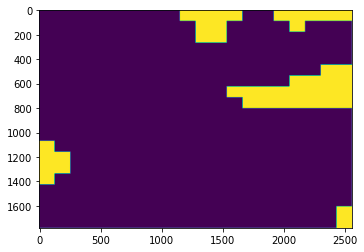

image area:  28036743.932750277
image area_mask:  24983299.608833134
area_max:  16741.568697553877


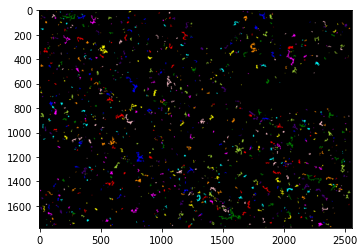


 area fraction:  0.03401939856104592 

FILE NAME: 210902_#8_150_20_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 95.0
MASK SIZE: 0.9856996137640449


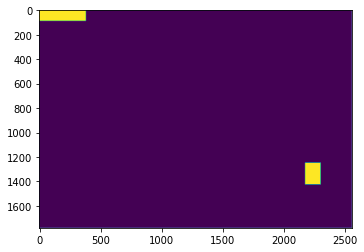

image area:  28036743.932750277
image area_mask:  27635807.665713377
area_max:  155891.63031603183


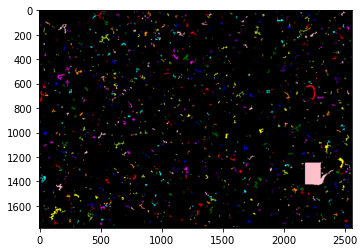


 area fraction:  0.035988592025358083 

FILE NAME: 210902_#9_150_30_1um_i001.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 90.0
MASK SIZE: 0.9980960323033707


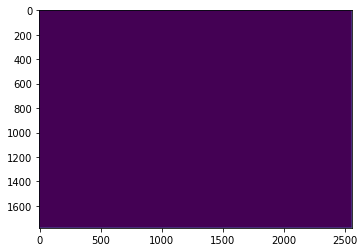

image area:  28036743.932750277
image area_mask:  27983362.877983656
area_max:  13677.510920493301


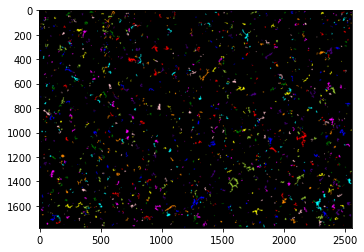


 area fraction:  0.04192340648676648 

FILE NAME: 210902_#9_150_30_1um_i002.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 96.0
MASK SIZE: 0.9434827071629214


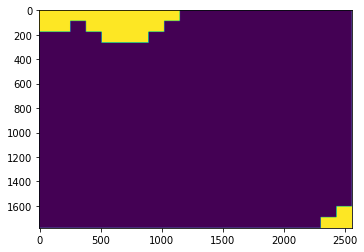

image area:  28036743.932750277
image area_mask:  26452183.06570484
area_max:  12163.940211342897


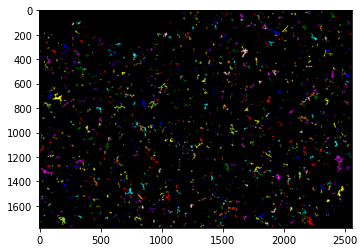


 area fraction:  0.03898988666416434 

FILE NAME: 210902_#9_150_30_1um_i003.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 100.0
MASK SIZE: 0.9831741573033708


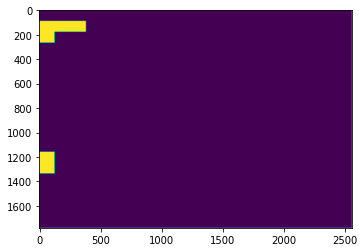

image area:  28036743.932750277
image area_mask:  27565002.08961215
area_max:  12391.591090361451


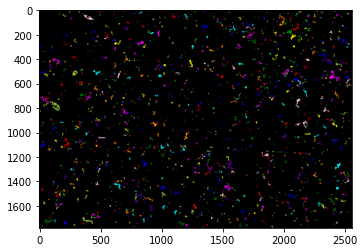


 area fraction:  0.039953316928250465 

FILE NAME: 210902_#9_150_30_1um_i004.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 132.0
MASK SIZE: 0.943353669241573


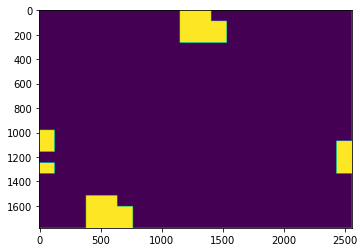

image area:  28036743.932750277
image area_mask:  26448565.262546387
area_max:  39580.48931692911


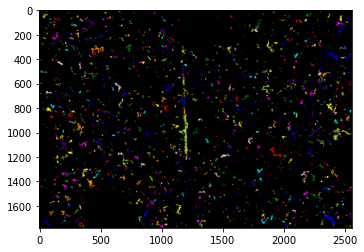


 area fraction:  0.04426649001036881 

FILE NAME: 210902_#9_150_30_1um_i005.tif
DATE: 09/03/2021
IMAGE SIZE [pixels]: 2560 x 1780
PIXEL SIZE [nm]: 2.480469
IMAGE SIZE [nm]: 6350.0 x 4415.0
IMAGE AREA [nm]: 28036743.932750277
Median Rectangle Box size: 89 x 128
Median intensity: 118.0
MASK SIZE: 0.993162965238764


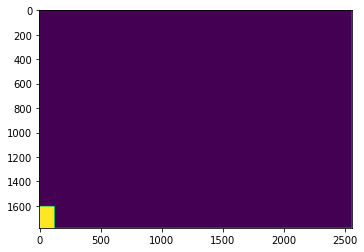

image area:  28036743.932750277
image area_mask:  27845055.73989019
area_max:  25730.7020555569


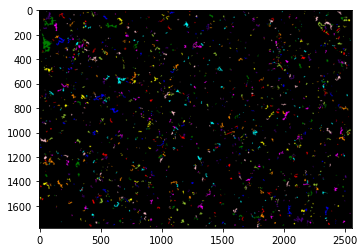


 area fraction:  0.03834753728909199 



,file name,area_fraction
0,210902_#1_50_10_1um_i004.tif,0.014564
1,210902_#1_50_10_1um_i005.tif,0.011339
2,210902_#1_50_10_1um_i006.tif,0.013914
3,210902_#1_50_10_1um_i007.tif,0.014357
4,210902_#2_50_20_1um_i001.tif,0.015472
5,210902_#2_50_20_1um_i002.tif,0.012742
6,210902_#2_50_20_1um_i003.tif,0.012301
7,210902_#2_50_20_1um_i004.tif,0.009310
8,210902_#3_50_30_1um_i001.tif,0.012184
9,210902_#3_50_30_1um_i002.tif,0.007058


In [ ]:
area_fraction_pd = []
for tif in filelist:
    img,sem_dict,width, height,pixelsize,image_area = loadfile(tif)
    img2, median_img,mask = uniform(20,20)
    unique, counts = np.unique(mask, return_counts=True)
    area_size_mask = dict(zip(unique, counts))
    print('MASK SIZE:',area_size_mask[False]/(area_size_mask[True]+area_size_mask[False]))
    plt.imshow(mask)
    plt.show()
    img_segm = segmentation(20)
    img2_label, img2_label_overlay, data_nm = label_img()
    print('area_max: ',data_nm['area'].max())
    plt.imshow(img2_label_overlay, vmax=1)
    plt.show()
    data_nm = data_nm[data_nm['area']<100000]
    print('\n area fraction: ',data_nm['area_fraction'].sum(),'\n')
    area_fraction_pd.append([sem_dict['ImageName'],data_nm['area_fraction'].sum()])

area_fraction_pd = pd.DataFrame(area_fraction_pd, columns=['file name', 'area_fraction'])
area_fraction_pd

In [ ]:
area_fraction_pd.values

array([['210902_#1_50_10_1um_i004.tif', 0.014564025909246603],
       ['210902_#1_50_10_1um_i005.tif', 0.011338701565779456],
       ['210902_#1_50_10_1um_i006.tif', 0.013914470929778025],
       ['210902_#1_50_10_1um_i007.tif', 0.01435681864109143],
       ['210902_#2_50_20_1um_i001.tif', 0.01547245572907292],
       ['210902_#2_50_20_1um_i002.tif', 0.012741866805995601],
       ['210902_#2_50_20_1um_i003.tif', 0.012301492106145479],
       ['210902_#2_50_20_1um_i004.tif', 0.009309758406307884],
       ['210902_#3_50_30_1um_i001.tif', 0.012183874541192236],
       ['210902_#3_50_30_1um_i002.tif', 0.007058274367854627],
       ['210902_#3_50_30_1um_i003.tif', 0.0064530367562422],
       ['210902_#3_50_30_1um_i004.tif', 0.01265967133498797],
       ['210902_#4_100_30_1um_i002.tif', 0.028744521623536086],
       ['210902_#4_100_30_1um_i003.tif', 0.04937755520241141],
       ['210902_#4_100_30_1um_i004.tif', 0.051338505817919496],
       ['210902_#4_100_30_1um_i005.tif', 0.045649335571527

In [ ]:
area_size_mask

{False: 4525645, True: 31155}

In [ ]:
print(area_size_mask[False])

4287271


In [ ]:
data_nm['area'].max()

6491.126415258854